<a href="https://colab.research.google.com/github/Shubhamkumar-op/Deep_Learning/blob/main/Transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import zipfile 

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip our data 
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip","r")
zip_ref.extractall()
zip_ref.close()

--2023-03-10 07:05:39--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.214.128, 173.194.216.128, 173.194.215.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.214.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   204MB/s    in 0.8s    

2023-03-10 07:05:40 (204 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SHAPE=(224,224)
BATCH_SIZE=32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(1/255.)
test_datagen = ImageDataGenerator(1/255.)

print("training_Images")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size=IMG_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode="categorical")

print("testing_Images")
test_data = train_datagen.flow_from_directory(test_dir,
                                                 target_size=IMG_SHAPE,
                                                 batch_size=BATCH_SIZE,
                                                 class_mode="categorical")

training_Images
Found 750 images belonging to 10 classes.
testing_Images
Found 2500 images belonging to 10 classes.


In [ ]:
#tensorboard callback
import tensorflow as tf
import datetime

def create_tensorboard_callback(dir_name,experiment_name):
  log_dir = dir_name+"/"+experiment_name+"/"+datetime.datetime.now().strftime("%H%M%S-%d%m%Y")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"saving tensorboard log files to {log_dir}")
  return tensorboard_callback

In [ ]:
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"
efficentnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [ ]:
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
def create_model(model_url,num_classes=10):
  #download the pretrained model and save it as keras layers
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False,
                                           name="feature_extraction_layer",
                                           input_shape=IMG_SHAPE+(3,))
  #create our own model
  model=tf.keras.Sequential([
      feature_extractor_layer,
      layers.Dense(num_classes,activation='softmax',name='output_layer')
  ])

  return model

In [ ]:
resnet_model = create_model(resnet_url,
                            num_classes=train_data_10_percent.num_classes)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [ ]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [ ]:
resnet_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [ ]:
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                             experiment_name="resnet50v2")])

saving tensorboard log files to tensorflow_hub/resnet50v2/070551-10032023


/usr/local/lib/python3.9/dist-packages/keras/preprocessing/image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


Epoch 1/5
24/24 [==============================] - 38s 1s/step - loss: 120.7889 - accuracy: 0.1227 - val_loss: 72.3016 - val_accuracy: 0.1328
Epoch 2/5
24/24 [==============================] - 19s 813ms/step - loss: 54.6962 - accuracy: 0.1640 - val_loss: 37.5034 - val_accuracy: 0.1928
Epoch 3/5
24/24 [==============================] - 17s 751ms/step - loss: 31.4007 - accuracy: 0.2293 - val_loss: 41.5161 - val_accuracy: 0.1708
Epoch 4/5
24/24 [==============================] - 18s 756ms/step - loss: 36.7019 - accuracy: 0.2200 - val_loss: 36.2771 - val_accuracy: 0.1784
Epoch 5/5
24/24 [==============================] - 18s 746ms/step - loss: 32.0399 - accuracy: 0.2547 - val_loss: 37.4919 - val_accuracy: 0.2092


In [ ]:
import matplotlib.pyplot as plt
def plot_loss_curves(history):
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  #plot loss
  plt.plot(epochs,loss,label="training_loss")
  plt.plot(epochs,val_loss,label="val_loss")
  plt.title("loss")
  plt.xlabel("epochs")
  plt.legend()

  #plot accuracy
  plt.figure()
  plt.plot(epochs,accuracy,label="training_accuracy")
  plt.plot(epochs,val_accuracy,label="val_accuracy")
  plt.title("accuracy")
  plt.xlabel("epochs")
  plt.legend()

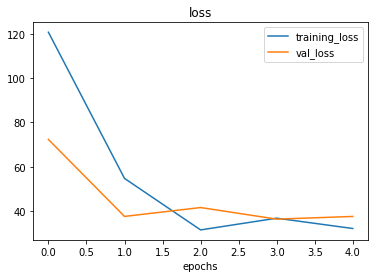

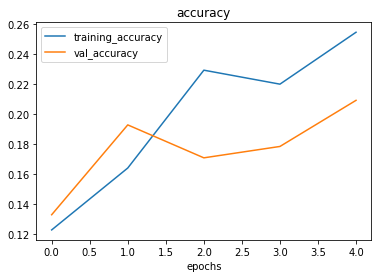

In [ ]:
plot_loss_curves(resnet_history)

In [ ]:
efficient_model = create_model(efficentnet_url,
                               num_classes=train_data_10_percent.num_classes)

In [ ]:
efficient_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [ ]:
efficient_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                             experiment_name="efficientnetb0")])

saving tensorboard log files to tensorflow_hub/efficientnetb0/071727-10032023
Epoch 1/5
24/24 [==============================] - 18s 736ms/step - loss: 25.2549 - accuracy: 0.2640 - val_loss: 25.6665 - val_accuracy: 0.2356
Epoch 2/5
24/24 [==============================] - 19s 799ms/step - loss: 20.8930 - accuracy: 0.2813 - val_loss: 31.5983 - val_accuracy: 0.2304
Epoch 3/5
24/24 [==============================] - 17s 711ms/step - loss: 19.8845 - accuracy: 0.3147 - val_loss: 30.6486 - val_accuracy: 0.1840
Epoch 4/5
24/24 [==============================] - 25s 1s/step - loss: 24.7468 - accuracy: 0.2827 - val_loss: 40.2597 - val_accuracy: 0.2204
Epoch 5/5
24/24 [==============================] - 24s 1s/step - loss: 27.1846 - accuracy: 0.3280 - val_loss: 40.9934 - val_accuracy: 0.1868


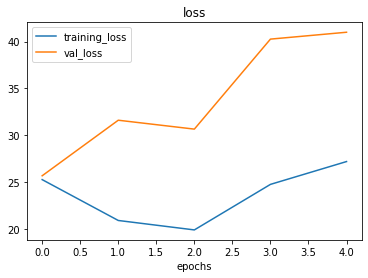

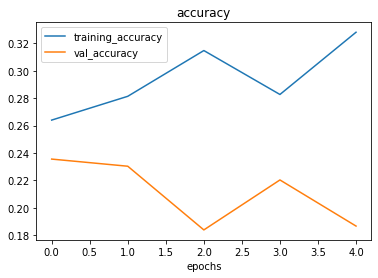

In [ ]:
plot_loss_curves(efficient_history)